# BIG DATA CW2 - SVHN Digit Classification Using a CNN 
---
**student ID'S**: Mike Shier **(UP2127137)**, Jack Elliott **(UP2119254)** and **(2088294)**

**Dataset**: SVHN (Street View House Numbers)

**Main Objectives**: Classifing digits from (0-9) from a 32 x 32RGB image using a loaded CNN Model. 

---

 ## Step - (1): Data Collection Downloaded from Urls on the SVHN Website

 Using the SVHN dataset the .mat files for training and testing were correctly downloaded, the files being curently in MATLAB format hence the (.mat). Files are only being downloaded once to save time and bandwidth, 
 the files contain over 600,000 labled 32x32 pixle RGB images of digits 0-9 provided on Google Streetview.

In [1]:
import os
import urllib.request

In [2]:
# Creating a folder for the data to be handled
os.makedirs("data", exist_ok= True)

In [3]:
# Defining the URLs for training and testing the data
urls = {
    "train":"http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
    "test":"http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
    "extra":"http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"
}

In [4]:
# Downloading functions
def download_svhn():
    for name, url in urls.items():
        filepath = f"data/{name}_32x32.mat"
        if not os.path.exists(filepath):
            print(f"Downloading {name}data...")
            urllib.request.urlretrieve(url,filepath)
            print(f"{name.capitalize()}Data has been download sucessfully.")
        else:
            print(f"{name.capitalize()} Data already exists.")

download_svhn()

print("All SVHN files are curently available and have been downloaded.")

Train Data already exists.
Test Data already exists.
Extra Data already exists.
All SVHN files are curently available and have been downloaded.


In [5]:
for name in urls:
    file_path = f"data/{name}_32x32.mat"
    print(f"{name} File size:{os.path.getsize(file_path) / (1024**2):.2f} MB")

train File size:173.61 MB
test File size:61.30 MB
extra File size:1267.70 MB


# Step - (2): Preprocess the SVHN Dataset

This loads the .mat files downloaded in step 1 and converts the data presented into the correct format, normalizing the pixel values to [0, 1], fixing the label format to (10-0), and correctly splits the training set into 80% training and 20% validation using satisfied sampeling.  
 

In [6]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
import gc
import tensorflow as tf

2025-05-30 00:08:10.022002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 00:08:10.040409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 00:08:10.313592: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 00:08:10.469755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748563690.730881   46352 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748563690.82

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-05-30 00:08:14.672953: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# Loading the data 
train_data = scipy.io.loadmat("data/train_32x32.mat")
test_data = scipy.io.loadmat("data/test_32x32.mat")

In [9]:
import gc

# Transposing image arrays to the correct shape: e.g.(32,32,3)
X_train = np.transpose(train_data['X'], (3, 0, 1, 2))
y_train = train_data['y'].flatten()
y_train[y_train == 10] = 0

X_test = np.transpose(test_data['X'], (3, 0, 1, 2))
y_test = train_data['y'].flatten()
y_test[y_test == 10] = 0


del train_data, test_data
gc.collect()

0

In [10]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [11]:
import gc

extra_data = scipy.io.loadmat("data/extra_32x32.mat")
y_extra = extra_data['y'].flatten()
y_extra[y_extra == 10] = 0

batch_size = 1000 #reduced from 10,000 to help preevent kernal dying.

for i in range(0, 50000, batch_size):
    X_batch_raw = extra_data['X'][:, :, :, i:i+batch_size]
    X_batch = np.transpose(X_batch_raw, (3, 0, 1, 2)).astype('float32') / 255.0
    y_batch = y_extra[i:i+batch_size]

    np.savez_compressed(f"data/X_extra_{i}_{i+batch_size}.npz", X_batch)
    np.savez_compressed(f"data/y_extra_{i}_{i+batch_size}.npz", y_batch)

    del X_batch_raw, X_batch, y_batch
    gc.collect()

del extra_data, y_extra
gc.collect()

print(" Extra data saved in compressed chunks.")

 Extra data saved in compressed chunks.


In [12]:
# Spitting training sets: 80% training, 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)

In [13]:
y_train_cat = to_categorical(y_train_split,num_classes = 10)
y_val_cat = to_categorical(y_val_split, num_classes = 10)

In [14]:
X_train_split = X_train_split[:10000]
y_train_cat = y_train_cat[:10000]
X_val_split = X_val_split[:2000]
y_val_cat = y_val_cat[:2000]

In [15]:
# Printing Shapes
print("Train set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val_split.shape, y_val_split.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Train set shape: (10000, 32, 32, 3) (58605,)
Validation set shape: (2000, 32, 32, 3) (14652,)
Testing set shape: (26032, 32, 32, 3) (73257,)


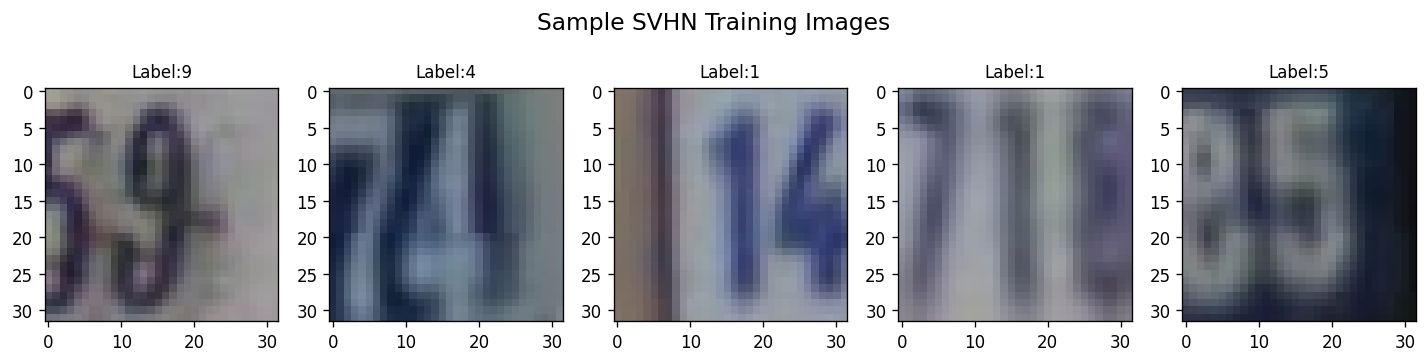

In [16]:
# Visulising some samples 
plt.figure(figsize=(12,3), dpi= 120)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_split[i], interpolation='nearest')
    plt.title(f"Label:{y_train_split[i]}", fontsize = 10)
    plt.axis('on')

plt.suptitle("Sample SVHN Training Images", fontsize = 14)
plt.tight_layout()
plt.show()
    

##### Brief Explaination of the labels above the images
 The SVHN Dataset is trained to identify the correct centered number/digit rather than reading the entire sequence. This allows the model to foucs on one digit at a time and reflects real-world structure. 

 for example:

 **- Image is showing "157" it maybe labled as '1', this is because the center digit is '1'**

 **- An image labled as "49" maybe labled as '9', this is if '9' is the central digit.**

 Each SVHM image is labled with a single digit, even though the image may display multiple digits e.g. the label corrosponds to the **digit that is centered or most prominat throughout the image**.

# Step - (3): Training of the CNN Model

In this step a CNN (convolutional nueral network) will be built and trained using preprocessed training and validation sets. The model is designed to calsify digits (0-9) from 32x32 RGB images using severl convolutional and pooling layers followed by dense layers. The training history will be plotted to allow for visulization of the learning progress and identify overfitting or underfitting.


In [17]:
from tensorflow.keras.utils import to_categorical


y_train_cat = to_categorical(y_train_split, num_classes = 10)
y_val_cat = to_categorical(y_val_split, num_classes = 10)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
checkpoint = ModelCheckpoint("model_opt.keras", save_best_only = True)

In [19]:
X_train_split = X_train_split[:10000]
y_train_split = y_train_split[:10000]

In [20]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train_split)

In [21]:
X_val_split = X_val_split[:2000]
y_val_split = y_val_split[:2000]
y_val_cat = to_categorical(y_val_split)

## CNN(1) Below is the Baseline SVHN model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_base = Sequential([
    Conv2D(32,(3, 3), activation = 'relu', input_shape = (32, 32, 3)),
    MaxPooling2D(),

    Conv2D(64,(3, 3), activation = 'relu'),
    MaxPooling2D(),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')

])

model_base.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
history_base = model_base.fit(
    X_train_split, y_train_cat,
    validation_data = (X_val_split, y_val_cat),
    epochs = 10,
    batch_size = 64
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1932 - loss: 2.2536 - val_accuracy: 0.2860 - val_loss: 2.0420
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.3755 - loss: 1.8567 - val_accuracy: 0.6795 - val_loss: 1.1144
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6121 - loss: 1.2155 - val_accuracy: 0.7790 - val_loss: 0.8139
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6887 - loss: 0.9984 - val_accuracy: 0.7825 - val_loss: 0.7795
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7324 - loss: 0.8722 - val_accuracy: 0.8185 - val_loss: 0.6482
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7594 - loss: 0.8022 - val_accuracy: 0.8360 - val_loss: 0.5819
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7721 - loss: 0.7560 - val_accuracy: 0.8515 - val_loss: 0.5508
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7813 - loss: 0.7062 - val_accu

## CNN(2) - Below is the optimised SVHN model 

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model_opt = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(),


    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),


    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(10, activation = 'softmax')
])



model_opt.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history_opt = model_opt.fit(
    X_train_split, y_train_cat,
    validation_data = (X_val_split, y_val_cat),
    epochs = 15,
    batch_size = 64,
    callbacks = [early_stop, checkpoint]
)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.2156 - loss: 2.7550 - val_accuracy: 0.2135 - val_loss: 2.7818
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5974 - loss: 1.2144 - val_accuracy: 0.4970 - val_loss: 1.5134
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7446 - loss: 0.8269 - val_accuracy: 0.6805 - val_loss: 1.0244
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.7887 - loss: 0.6710 - val_accuracy: 0.8445 - val_loss: 0.5422
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8184 - loss: 0.5988 - val_accuracy: 0.8200 - val_loss: 0.5887
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8333 - loss: 0.5346 - val_accuracy: 0.8530 - val_loss: 0.5014
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8518 - loss: 0.4655 - val_accuracy: 0.8320 - val_loss: 0.5464
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8566 - loss: 0.4541 - val_acc

In [25]:
X_train_split = X_train_split[:10000]
y_train_cat = y_train_cat[:10000]

X_val_split = X_val_split[:2000]
y_val_cat = y_val_cat[:2000]

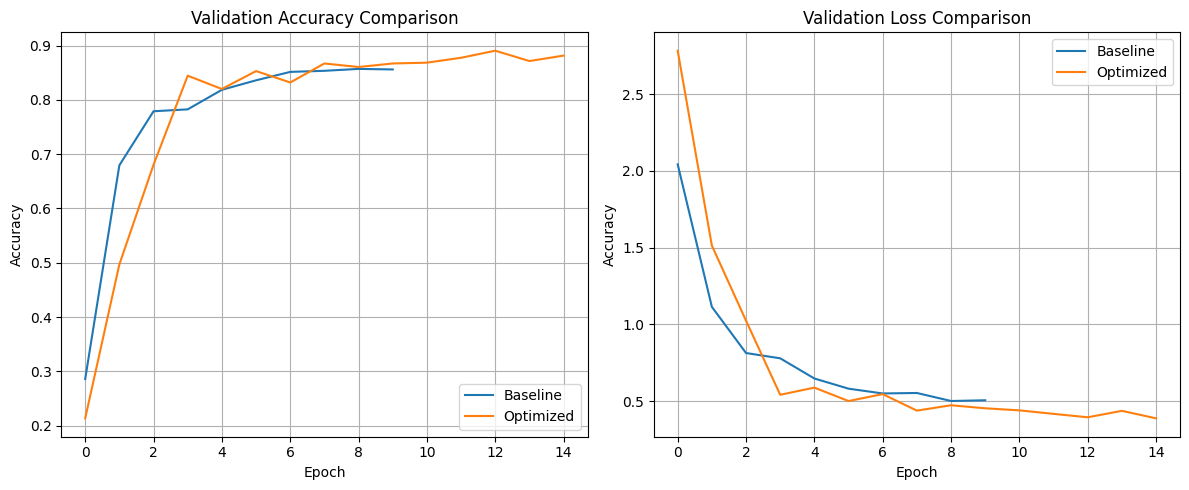

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 5))

# Accuracy 
plt.subplot(1, 2, 1)
plt.plot(history_base.history['val_accuracy'], label = 'Baseline')
plt.plot(history_opt.history['val_accuracy'], label = 'Optimized')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('on')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_base.history['val_loss'], label = 'Baseline')
plt.plot(history_opt.history['val_loss'], label = 'Optimized')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.grid('on')
plt.show()


# Step - (4): Evaluation of the Trained CNN model

to evaluate the current performance of the trained model, a classification report and confusion matrix will be used.
These will provide insights into how well the model distinguishes between digit classes.
The predictions are made based on the validation dataset (used a proxy for unseen data tests carried out)


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

In [28]:
y_val_true = np.argmax(y_val_cat, axis = 1)

y_val_pred = np.argmax(model_opt.predict(X_val_split), axis = 1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


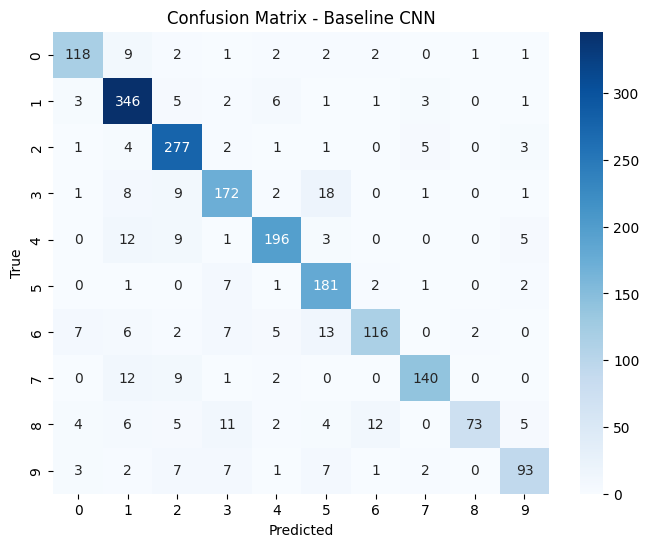

,precision,recall,f1-score,support
0,0.86,0.86,0.86,138.00
1,0.85,0.94,0.89,368.00
2,0.85,0.94,0.89,294.00
3,0.82,0.81,0.81,212.00
4,0.90,0.87,0.88,226.00
5,0.79,0.93,0.85,195.00
6,0.87,0.73,0.79,158.00
7,0.92,0.85,0.89,164.00
8,0.96,0.60,0.74,122.00
9,0.84,0.76,0.79,123.00


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicting and converting from one hot to label
y_val_true = np.argmax(y_val_cat, axis = 1)
y_val_pred_base = np.argmax(model_base.predict(X_val_split), axis = 1)


# Confusion Matrix
cm_base = confusion_matrix(y_val_true, y_val_pred_base)

plt.figure(figsize = (8, 6))
sns.heatmap(cm_base, annot = True, fmt = 'd', cmap = 'Blues', xticklabels= range(10), yticklabels= range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline CNN')
plt.show()

# Classifcation report

report_base = classification_report(y_val_true, y_val_pred_base, output_dict = True)
report_df_base = pd.DataFrame(report_base).transpose().round(2)
report_df_base


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


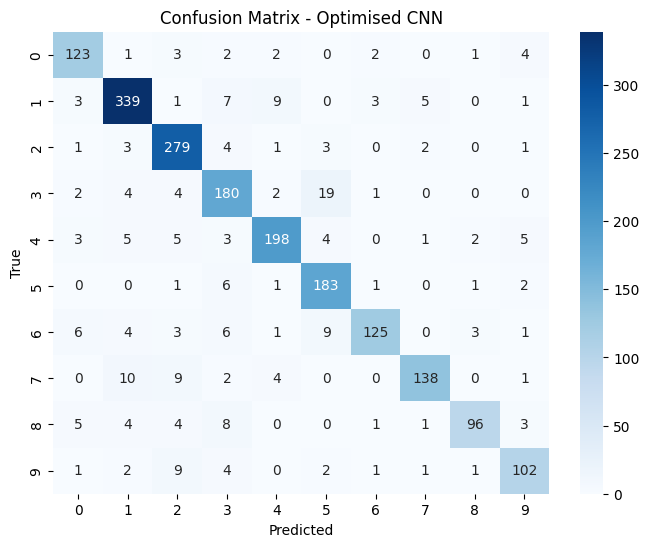

,precision,recall,f1-score,support
0,0.85,0.89,0.87,138.00
1,0.91,0.92,0.92,368.00
2,0.88,0.95,0.91,294.00
3,0.81,0.85,0.83,212.00
4,0.91,0.88,0.89,226.00
5,0.83,0.94,0.88,195.00
6,0.93,0.79,0.86,158.00
7,0.93,0.84,0.88,164.00
8,0.92,0.79,0.85,122.00
9,0.85,0.83,0.84,123.00


In [30]:
y_val_pred_opt = np.argmax(model_opt.predict(X_val_split), axis = 1)

# Confusion Matrix
cm_opt = confusion_matrix(y_val_true, y_val_pred_opt)

plt.figure(figsize = (8, 6))
sns.heatmap(cm_opt, annot = True, fmt = 'd', cmap = 'Blues', xticklabels= range(10), yticklabels= range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Optimised CNN')
plt.show()

# Classifcation report

report_opt = classification_report(y_val_true, y_val_pred_opt, output_dict = True)
report_df_opt = pd.DataFrame(report_opt).transpose().round(2)
report_df_opt


# Step - (5): Prediction


In [ ]:
model_opt.save("best_model.keras")

: 

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Loading the trained model
model = load_model('best_model.keras')

# Running predictions based on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

# Plotting predictions
plt.figure(figsize = (12, 4), dpi = 120)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i], cmap = 'grey')
    plt.title(f"Pred: {y_pred[i]}\nConf: {y_pred_probs[i][y_pred[i]]:.2f}", fontsize = 10)
    plt.title(f"True: {y_test[i]}\nPred: {y_pred[i]}\nConf: {y_pred_probs[i][y_pred[i]]:.2f}", fontsize=10)
    plt.axis("off")

plt.suptitle("SVHN Model Predictions on Test Images", fontsize = 14)
plt.tight_layout()
plt.show()